In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

import os
import sys

In [9]:
cases = pd.read_csv("CaseData.csv")
dallas = cases[cases["County Name"] == "Dallas"]
dallas = dallas.set_index("Date")
dallas = dallas[["Cases"]]
dallas.index = pd.to_datetime(dallas.index)
dallas.head()

,Cases
Date,
2020-03-04,0.0
2020-03-05,0.0
2020-03-06,0.0
2020-03-09,0.0
2020-03-10,0.0


In [12]:
dallas = dallas[:40]

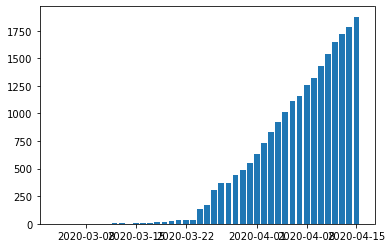

In [13]:
plt.bar(dallas.index, dallas["Cases"])
plt.show()

In [14]:
dmin = min(dallas.index)
dmax = max(dallas.index)

idx = pd.date_range(dmin, dmax)
dallas = dallas.reindex(idx)

In [15]:
dallas = dallas.sort_index()

In [16]:
new_cases_obs = dallas.diff()
new_cases_obs = new_cases_obs.dropna()

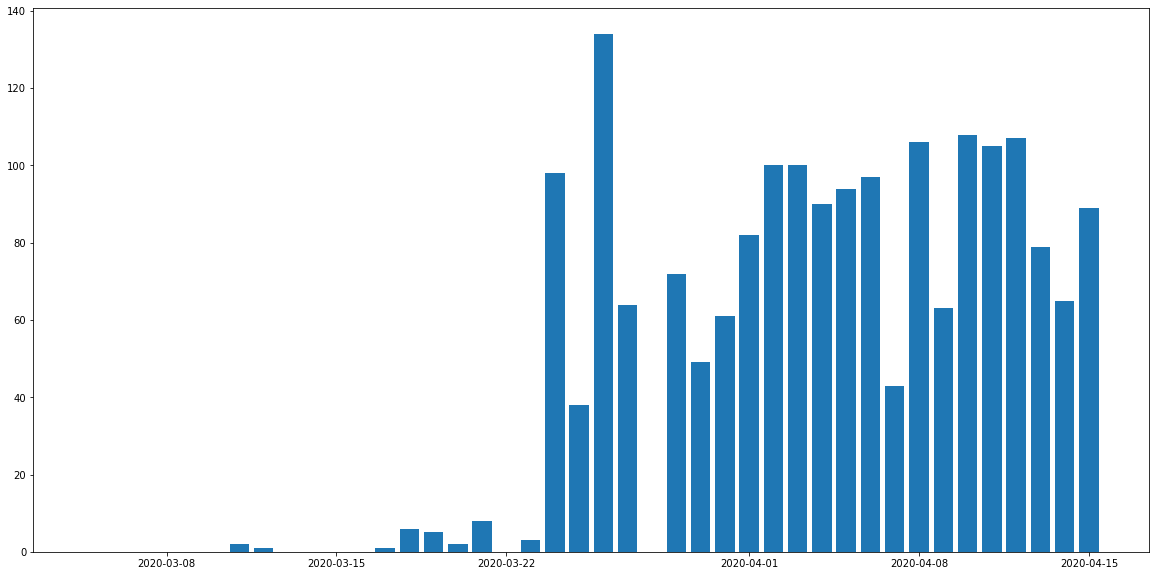

In [17]:
plt.figure(figsize=(20,10))
plt.bar(new_cases_obs.index, new_cases_obs["Cases"])
plt.show()

# Now set up a model


In [18]:
import datetime
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm

#import logging
#log = logging.getLogger(__name__)

try:
    import covid19_inference as cov19
    print("Option 1")
except ModuleNotFoundError:
    sys.path.append("../")
    import covid19_inference as cov19
    print("Option 2")

Option 2


In [11]:
# Number of days the simulation starts earlier than the data.
# Should be significantly larger than the expected delay in order to always fit the same number of data points.
diff_data_sim = 16
# Number of days in the future (after date_end_data) to forecast cases
num_days_forecast = 10

# Change point midpoint dates
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 11)
#prior_date_strong_dist_begin = datetime.datetime(2020, 3, 18)
#prior_date_contact_ban_begin = datetime.datetime(2020, 3, 25)

# Structures change points in a dict. Variables not passed will assume default values.
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=0.2,
        pr_sigma_lambda=0.5,
        pr_sigma_transient_len=0.5,
    ),
#     dict(
#         pr_mean_date_transient=prior_date_strong_dist_begin,
#         pr_sigma_date_transient=1.5,
#         pr_median_lambda=1 / 8,
#         pr_sigma_lambda=0.5,
#         pr_sigma_transient_len=0.5,
#     ),
#     dict(
#         pr_mean_date_transient=prior_date_contact_ban_begin,
#         pr_sigma_date_transient=1.5,
#         pr_median_lambda=1 / 8 / 2,
#         pr_sigma_lambda=0.5,
#         pr_sigma_transient_len=0.5,
#     ),
]

# Stores the model parameters in a dict
params_model = dict(
    new_cases_obs=new_cases,
    data_begin=dmin,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=1330000,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10

# The true model is defined in a context manager.
# Check https://docs.pymc.io/notebooks/getting_started.html for details on it.
with cov19.model.Cov19Model(**params_model) as this_model:

    # Create the array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # Adds the recovery rate mu to the model as a random variable
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference. It is not
    # necessary to use it, one can simply remove it and use the default argument for
    # pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log, mu=mu, pr_median_delay=pr_delay
    )

    # Use lambda_t_log and mu as parameters for the SIR model.
    # The SIR model generates the inferred new daily cases.
    new_cases = cov19.model.SIR(lambda_t_log=lambda_t_log, mu=mu, pr_I_begin=prior_I)

    # Delay the cases by a lognormal reporting delay and add them as a trace variable
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        pr_mean_of_median=pr_delay,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(cases=new_cases, name_cases="new_cases")

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(cases=new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


In [12]:
with this_model:
    maps = pm.find_MAP()

In [13]:
maps

{'sigma_lambda_0_hc_L1_log__': array(-1.06142572),
 'lambda_0_hc_L1_log_': array(-0.7373498),
 'lambda_0_hc_L2_log_raw_': array([0.31166012]),
 'sigma_lambda_1_hc_L1_log__': array(-0.37481346),
 'lambda_1_hc_L1_log': array(-1.8715417),
 'lambda_1_hc_L2_log_raw_': array([-0.68871238]),
 'sigma_transient_day_1_L1_log__': array(-1.39504243),
 'transient_day_1_hc_L1': array(22.50228506),
 'transient_day_1_hc_L2_raw_': array([-0.00158337]),
 'sigma_transient_len_1_log__': array(-2.53833305),
 'transient_len_1_hc_L1_log': array(1.3250098),
 'transient_len_1_hc_L2_log_raw_': array([-0.01457539]),
 'mu_log__': array(-2.50585335),
 'I_begin_ratio_log': array([1.30248704]),
 'delay_hc_sigma_log__': array(-1.28362683),
 'delay_hc_L1_log': array(2.21212628),
 'delay_hc_L2_log_raw_': array([-0.68841219]),
 'sigma_weekend_factor_log__': array(-1.66379903),
 'weekend_factor_hc_L1_log': array(-1.53361628),
 'weekend_factor_hc_L2_log_raw_': array([-0.30066896]),
 'offset_modulation_rad_circular__': arr

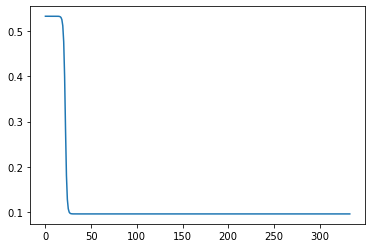

In [16]:
plt.plot(maps['lambda_t'])

# Now add the GPs

In [51]:
# # For reference, here's the lambda_t_with_sigmoids function
# def lambda_t_with_sigmoids(
#     change_points_list,
#     pr_median_lambda_0,
#     pr_sigma_lambda_0=0.5,
#     model=None,
#     name_lambda_t="lambda_t",
# ):
#     """
#         Builds a time dependent spreading rate :math:`\lambda_t` with change points. The change points are marked by
#         a transient with a sigmoidal shape, with at

#         Parameters
#         ----------
#         change_points_list
#         pr_median_lambda_0
#         pr_sigma_lambda_0
#         model : :class:`Cov19Model`
#             if none, it is retrieved from the context

#         Returns
#         -------
#         lambda_t_log

#         TODO
#         ----
#         Documentation on this
#     """
#     log.info("Lambda_t with sigmoids")
#     # Get our default mode context
#     model = modelcontext(model)

#     # ?Get change points random variable?
#     lambda_log_list, tr_time_list, tr_len_list = _make_change_point_RVs(
#         change_points_list, pr_median_lambda_0, pr_sigma_lambda_0, model=model
#     )

#     # Build the time-dependent spreading rate
#     lambda_log_t_list = [
#         lambda_log_list[0] * tt.ones(model.sim_shape)
#     ]  # model.sim_shape = (time, state)
#     lambda_before = lambda_log_list[0]

#     # Loop over all lambda values and there corresponding transient values
#     for tr_time, tr_len, lambda_after in zip(
#         tr_time_list, tr_len_list, lambda_log_list[1:]
#     ):
#         # Create the right shape for the time array
#         t = np.arange(model.sim_shape[0])

#         # If the model is hierarchical repeatly add the t array to itself to match the shape
#         if model.is_hierarchical:
#             t = np.repeat(t[:, None], model.sim_shape[1], axis=-1)

#         # Applies standart sigmoid nonlinearity
#         lambda_t = tt.nnet.sigmoid((t - tr_time) / tr_len * 4) * (
#             lambda_after - lambda_before
#         )  # tr_len*4 because the derivative of the sigmoid at zero is 1/4, we want to set it to 1/tr_len

#         lambda_before = lambda_after
#         lambda_log_t_list.append(lambda_t)

#     # Sum up all lambda values from the list
#     lambda_t_log = sum(lambda_log_t_list)

#     # Create responding lambda_t pymc3 variable with given name (from parameters)
#     pm.Deterministic(name_lambda_t, tt.exp(lambda_t_log))

#     return lambda_t_log

In [9]:
# def lambda_t_gp(
#     mu,
#     model=None,
#     name_lambda_t="lambda_t",
# ):
#     log.info("Lambda_t with sigmoids")
#     # Get our default mode context
#     model = modelcontext(model)
    
#     # Priros for the GP hyperparameters
#     len_scale = 4.0
#     eta = 0.3    
#     cov_func = eta ** 2 * pm.gp.cov.ExpQuad(1, len_scale)
    
#     # Create GP
#     gp = pm.gp.Latent(cov_func=cov_func)
#     time_obs = np.arange(model.sim_shape[0])
#     log_r_t = gp.prior("log_r_t", X=np.arange(time_obs))
#     r_t = pm.Deterministic("r_t", tt.exp(log_r_t))
    
#     # Now translate r_t to lambda_t
#     log_lambda_t = pm.Deterministic("log_lambda_t", mu*log_r_t)
#     lambda_t = pm.Deterministic(name_lambda_t, tt.exp(log_lambda_t))
    
#     return log_lambda_t
    

In [19]:
# Number of days the simulation starts earlier than the data.
# Should be significantly larger than the expected delay in order to always fit the same number of data points.
diff_data_sim = 16
# Number of days in the future (after date_end_data) to forecast cases
num_days_forecast = 10

# Change point midpoint dates
#prior_date_mild_dist_begin = datetime.datetime(2020, 3, 11)
#prior_date_strong_dist_begin = datetime.datetime(2020, 3, 18)
#prior_date_contact_ban_begin = datetime.datetime(2020, 3, 25)

# Structures change points in a dict. Variables not passed will assume default values.
# change_points = [
#     dict(
#         pr_mean_date_transient=prior_date_mild_dist_begin,
#         pr_sigma_date_transient=1.5,
#         pr_median_lambda=0.2,
#         pr_sigma_lambda=0.5,
#         pr_sigma_transient_len=0.5,
#     ),
#     dict(
#         pr_mean_date_transient=prior_date_strong_dist_begin,
#         pr_sigma_date_transient=1.5,
#         pr_median_lambda=1 / 8,
#         pr_sigma_lambda=0.5,
#         pr_sigma_transient_len=0.5,
#     ),
#     dict(
#         pr_mean_date_transient=prior_date_contact_ban_begin,
#         pr_sigma_date_transient=1.5,
#         pr_median_lambda=1 / 8 / 2,
#         pr_sigma_lambda=0.5,
#         pr_sigma_transient_len=0.5,
#     ),
#]

# Stores the model parameters in a dict
params_model = dict(
    new_cases_obs=new_cases_obs,
    data_begin=dmin,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=1330000,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10

# The true model is defined in a context manager.
# Check https://docs.pymc.io/notebooks/getting_started.html for details on it.
with cov19.model.Cov19Model(**params_model) as this_model:

    # Adds the recovery rate mu to the model as a random variable
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)
    
    # Create the array of the time dependent infection rate lambda
    #cov19.model.uncorrelated_prior_I
    lambda_t_log = cov19.model.lambda_t_gp(
                        mu,
                        #model=None,
                        name_lambda_t="lambda_t",
    )
    
#     lambda_t_log = cov19.model.lambda_t_with_sigmoids(
#         pr_median_lambda_0=0.4,
#         pr_sigma_lambda_0=0.5,
#         change_points_list=change_points,
#         name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
#     )


    # This builds a decorrelated prior for I_begin for faster inference. It is not
    # necessary to use it, one can simply remove it and use the default argument for
    # pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log, mu=mu, pr_median_delay=pr_delay
    )

    # Use lambda_t_log and mu as parameters for the SIR model.
    # The SIR model generates the inferred new daily cases.
    new_cases = cov19.model.SIR(lambda_t_log=lambda_t_log, mu=mu, pr_I_begin=prior_I)

    # Delay the cases by a lognormal reporting delay and add them as a trace variable
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        pr_mean_of_median=pr_delay,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(cases=new_cases, name_cases="new_cases")

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(cases=new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


In [12]:
# with this_model:
#     maps = pm.find_MAP()

ValueError: array must not contain infs or NaNs
Apply node that caused the error: Solve{A_structure='upper_triangular', lower=False, overwrite_A=False, overwrite_b=False}(InplaceDimShuffle{1,0}.0, Elemwise{Composite{((i0 * i1) - i2)}}[(0, 0)].0)
Toposort index: 218
Inputs types: [TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(334, 334), (334, 334)]
Inputs strides: [(2672, 8), (2672, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[InplaceDimShuffle{1,0}(Solve{A_structure='upper_triangular', lower=False, overwrite_A=False, overwrite_b=False}.0)]]

Backtrace when the node is created(use Theano flag traceback__limit=N to make it longer):
  File "C:\Users\Jonathan\anaconda3\lib\site-packages\theano\gradient.py", line 1393, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "C:\Users\Jonathan\anaconda3\lib\site-packages\theano\gradient.py", line 1061, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "C:\Users\Jonathan\anaconda3\lib\site-packages\theano\gradient.py", line 1061, in <listcomp>
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "C:\Users\Jonathan\anaconda3\lib\site-packages\theano\gradient.py", line 1393, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "C:\Users\Jonathan\anaconda3\lib\site-packages\theano\gradient.py", line 1061, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "C:\Users\Jonathan\anaconda3\lib\site-packages\theano\gradient.py", line 1061, in <listcomp>
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "C:\Users\Jonathan\anaconda3\lib\site-packages\theano\gradient.py", line 1393, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "C:\Users\Jonathan\anaconda3\lib\site-packages\theano\gradient.py", line 1220, in access_term_cache
    input_grads = node.op.L_op(inputs, node.outputs, new_output_grads)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [20]:
with this_model:
    #step = pm.Metropolis()
    trace = pm.sample(draws=500, cores=1, chains=1)

C:\Users\Jonathan\anaconda3\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO     [pymc3] Sequential sampling (1 chains in 1 job)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_hc_L2_log_raw_, weekend_factor_hc_L1_log, sigma_weekend_factor, delay_hc_L2_log_raw_, delay_hc_L1_log, delay_hc_sigma, I_begin_ratio_log, log_r_t_rotated_, gp_eta_amp, gp_len_scale, mu]
INFO     [pymc3] NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_hc_L2_log_raw_, weekend_factor_hc_L1_log, sigma_weekend_factor, delay_hc_L2_log

Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 2718 seconds.
INFO     [pymc3] Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 2718 seconds.
There were 191 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There were 191 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO     [pymc3] Only one chain was sampled, this makes it impossible to run some convergence checks


In [27]:
trace.varnames

['mu_log__',
 'gp_len_scale_log__',
 'gp_eta_amp_log__',
 'log_r_t_rotated_',
 'I_begin_ratio_log',
 'delay_hc_sigma_log__',
 'delay_hc_L1_log',
 'delay_hc_L2_log_raw_',
 'sigma_weekend_factor_log__',
 'weekend_factor_hc_L1_log',
 'weekend_factor_hc_L2_log_raw_',
 'offset_modulation_rad_circular__',
 'sigma_obs_log__',
 'mu',
 'gp_len_scale',
 'gp_eta_amp',
 'log_r_t',
 'r_t',
 'log_lambda_t',
 'lambda_t',
 'I_begin',
 'new_I_t',
 'S_t',
 'I_t',
 'delay_hc_sigma',
 'delay_hc_L2_log',
 'delay_hc_L2',
 'delay_hc_L1',
 'delayed_cases',
 'sigma_weekend_factor',
 'weekend_factor_hc_L2_log',
 'weekend_factor_hc_L1',
 'weekend_factor_hc_L2',
 'offset_modulation_rad',
 'offset_modulation',
 'new_cases',
 'sigma_obs']

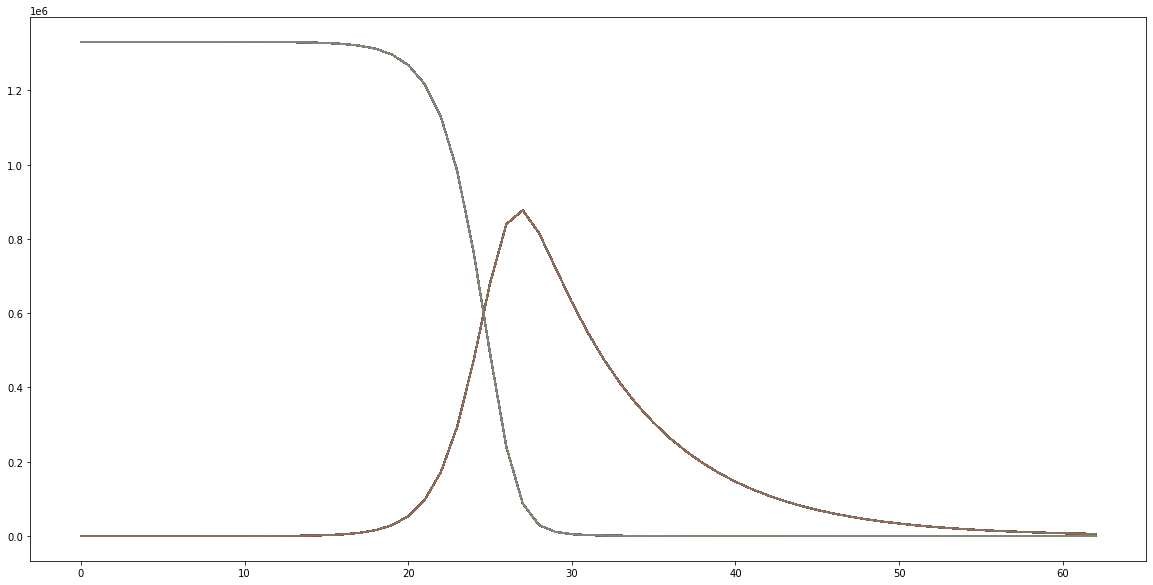

In [30]:
plt.figure(figsize=(20,10))
for j in range(250):
    plt.plot(trace['S_t'][j,:], alpha=0.1)
    plt.plot(trace['I_t'][j,:], alpha=0.1)

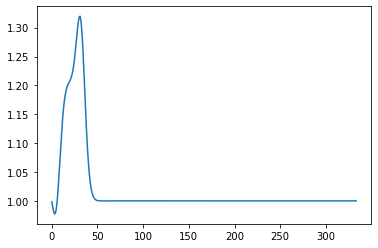

In [13]:
plt.plot(maps["r_t"])

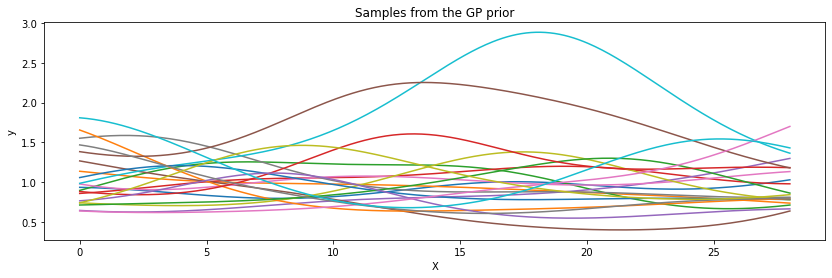

In [48]:
lengthscale = 7
eta = 0.3
cov = eta ** 2 * pm.gp.cov.ExpQuad(1, lengthscale)

X = np.linspace(0, 28, 300)[:, None]
K = cov(X).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, np.exp(pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K + 1e-12*np.eye(K.shape[0]), shape=(K.shape[0])).random(size=20).T))
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

In [15]:
this_model.sim_shape

(334, 1)

In [17]:
new_cases_obs.shape

(308, 1)